In [669]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision.transforms.functional import rotate
from scipy import ndimage
from torch.distributions import MultivariateNormal
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [889]:
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        self.skip_connection_dimension = input_size // 2
        self.transform_dimension = input_size - self.skip_connection_dimension

        # Define networks for scaling and translation coefficients
        self.scaling_network = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.skip_connection_dimension, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.transform_dimension)
            ) for _ in range(self.blocks)
        ])

        self.translation_network = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.skip_connection_dimension, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.transform_dimension)
            ) for _ in range(self.blocks)
        ])

    def encode(self, x):
        log_det_J = 0
        random_Qs = []
        for i in range(self.blocks):
            x_skip = x[:, :self.skip_connection_dimension]
            x_transform = x[:, self.skip_connection_dimension:]

            s = torch.exp(torch.tanh(self.scaling_network[i](x_skip)))
            t = self.translation_network[i](x_skip)

            x_transform = s * x_transform + t
            x = torch.cat([x_skip, x_transform], dim=1)
            log_det_J += torch.sum(torch.log(s), dim=1)

            if i < self.blocks - 1:
                random_matrix = torch.rand(self.input_size, self.input_size)
                #random_matrix = np.random.randn(self.input_size, self.input_size)
                random_Q = torch.qr(random_matrix)[0]
                random_Qs.append(random_Q)
                x = x @ random_Q

        Z = x  # Assign the final state of x to Z
        return Z, log_det_J, random_Qs


    def decode(self, z, random_Qs):
        for i in reversed(range(self.blocks)):
            if i < self.blocks - 1:
                z = z @ torch.inverse(random_Qs[i])

            z_skip = z[:, :self.skip_connection_dimension]
            z_transform = z[:, self.skip_connection_dimension:]


            s = torch.exp(torch.tanh(self.scaling_network[i](z_skip)))
            t = self.translation_network[i](z_skip)

            z_transform = (z_transform - t) / s
            z = torch.cat([z_skip, z_transform], dim=1)

        return z

    def train_inn(self, X_train, ts_size, epochs, lr=0.001, batch_size=128, k=None):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        losses = []
        for epoch in tqdm(range(epochs)):
            permutation = torch.randperm(X_train.size()[0])
            for i in range(0, X_train.size()[0], batch_size):
                indices = permutation[i:i + batch_size]
                batch_x = X_train[indices]

                optimizer.zero_grad()

                Z, log_det, Qs = self.encode(batch_x)
                loss = (-torch.sum(log_det) + 0.5 * torch.sum(Z**2))/len(batch_x)
                if k is not None:
                    mse_loss = self.check_invertibility(X_train, k)
                    #print(f"MSE:{10*mse_loss}, LOSS{loss}")
                    loss = 10*mse_loss + loss
               # print(loss)
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

        return losses, self
    def check_invertibility(self, X, k):
        """
        Check if the reverse pass is the exact inverse of the forward pass.
        """
        Z, _, random_Qs = self.encode(X)
        if k is not None:
            Z[:, k:] = 0
        X_reconstructed = self.decode(Z, random_Qs)



        criterion = nn.MSELoss()
        mse = criterion(X, X_reconstructed)
        #mse = torch.mean((X - X_reconstructed) ** 2)
        return mse
    def sample(self, num_samples, k=None):
        """
        Generates synthetic points using the trained RealNVP model.
        """
        Z = torch.randn(num_samples, self.input_size)
        if k is not None:
            #k_dim_sample = torch.randn(num_samples, k)
            #Z = torch.zeros((num_samples, self.input_size))
            Z[:, k:] = 0
 
           
        # Generate random_Qs for the sampling process
        random_Qs = []
        for i in range(self.blocks - 1):
            random_matrix = np.random.randn(self.input_size, self.input_size)
            random_Q = np.linalg.qr(random_matrix)[0].astype(np.float32)
            random_Qs.append(torch.tensor(random_Q))

        # Decode the sample to generate synthetic data
        synthetic_data = self.decode(Z, random_Qs)
        return synthetic_data
        

In [822]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)
        data = StandardScaler().fit_transform(data)
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None

    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        data = StandardScaler().fit_transform(data)
        noise =  np.random.normal(0, noise * data.max(), data.shape)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(Y_train), torch.FloatTensor(Y_test)

In [677]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.1, n_test=0.5,  name="moons")
print(X_train.std())

tensor(1.0088)


In [672]:
losses, nvp = RealNVP(2, 10, 35).train_inn(X_train, 500, 200)

100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


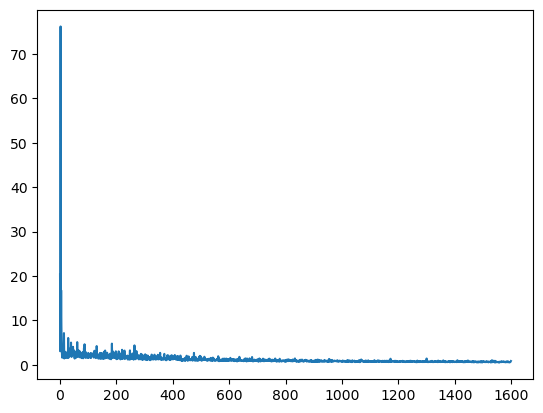

In [673]:
plt.plot(losses)

In [674]:
Z,_, Qs = nvp.encode(X_test)
reconstruced = nvp.decode(Z, Qs)
reconstruced = reconstruced.detach().numpy()
Z = Z.detach().numpy()

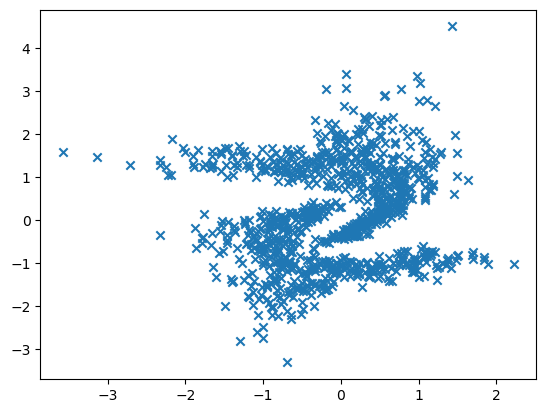

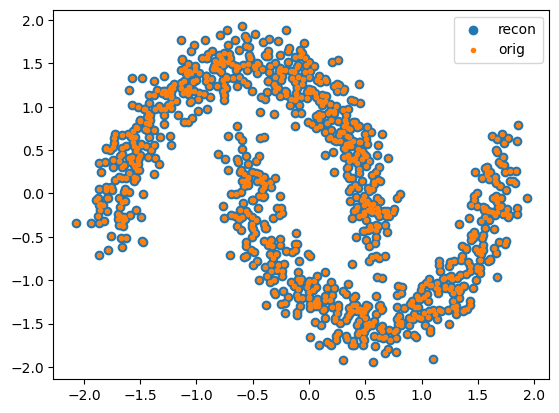

In [675]:
plt.scatter(Z[:, 0], Z[:, 1], label="Z", marker="x")
plt.figure()
plt.scatter(reconstruced[:, 0], reconstruced[:, 1], label="recon")
plt.scatter(X_test[:, 0], X_test[:, 1], label="orig", marker=".")
plt.legend()

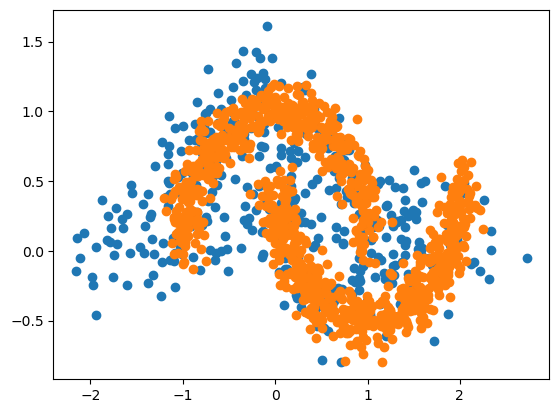

In [644]:
synth = nvp.sample(400)
plt.scatter(synth.detach().numpy()[:, 0], synth.detach().numpy()[:, 1])
plt.scatter(X_train[:, 0], X_train[:, 1])

# Task 3

## 1 digits

In [56]:
from sklearn.decomposition import PCA

In [823]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.0, n_test=0.1,  name="digits")

In [825]:
losses, nvp = RealNVP(64, 128, 10).train_inn(X_train, len(X_train), 100)

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


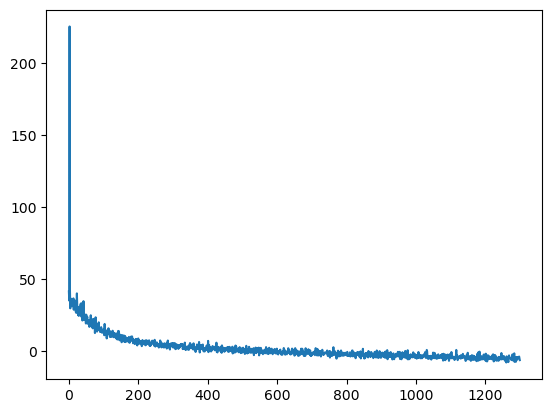

In [826]:
plt.plot(losses)

In [827]:
code_samples, _, _ = nvp.encode(X_test)
code_samples = [c.detach().numpy() for c in code_samples]


In [828]:
def plot_pca_projections(Z, components=[2,3]):
    Z_2D = PCA().fit_transform(Z)
    fig, axs = plt.subplots(*components)
    i = 0
    fig.suptitle("2D Projection of code space using PCA")
    for ax in axs.flatten():
        im = ax.hist2d(Z_2D[i], Z_2D[i+1],bins=[50,50], density=True)
        #ax.set(xlabel=f"PC{i}", ylabel=f"PC{i+1}")
        #ax.set(xlim=(-1, 1), ylim=(-1, 1))
        ax.legend()
        i += 1
    
    fig.tight_layout()
    fig.subplots_adjust(right=1)
    fig.colorbar(im[3], ax=axs.ravel().tolist(), shrink=0.95)

    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


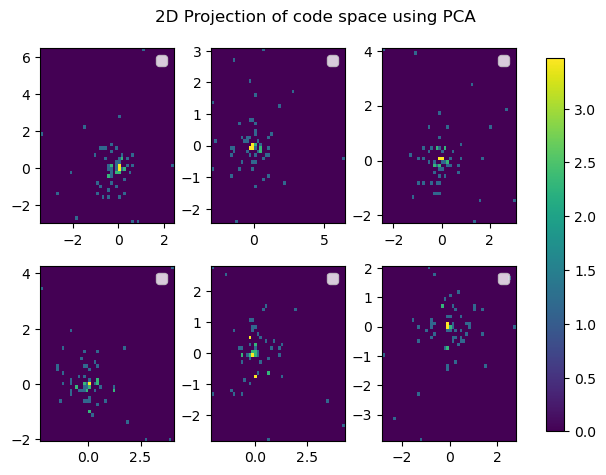

In [829]:
plot_pca_projections(code_samples)

In [830]:
def plot_samples(nvp, samples=[3,3], k=None):
    n_samples = samples[0] * samples[1]
    codes = nvp.sample(n_samples, k)
    fig, axs = plt.subplots(*samples)
    i = 0
    fig.suptitle("Reconstruction of random samples")
    for ax in axs.flatten():
        z = np.array([c.detach().numpy() for c in codes[i]]).reshape(8,8)
        im = ax.imshow(z)
        i += 1
        
    fig.tight_layout()
    fig.subplots_adjust(right=1)
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
    

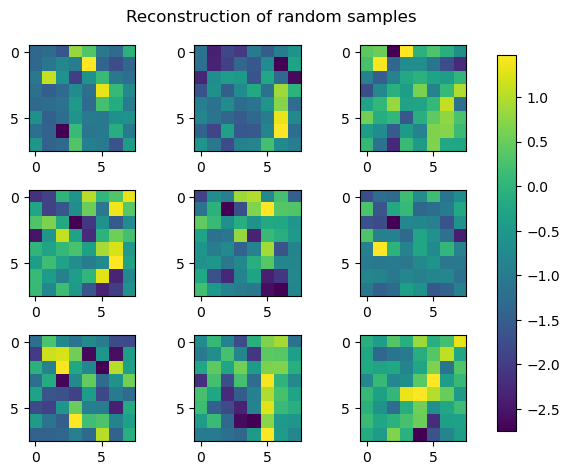

In [831]:
plot_samples(nvp)

In [896]:
losses, nvp = RealNVP(64, 400, 2).train_inn(X_train, len(X_train)/10, 20, k=8)

100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


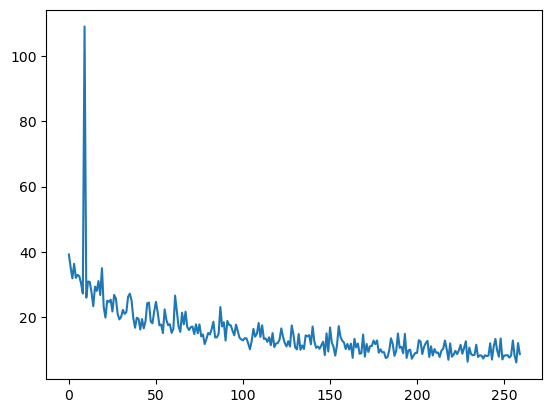

In [899]:
plt.plot(losses)

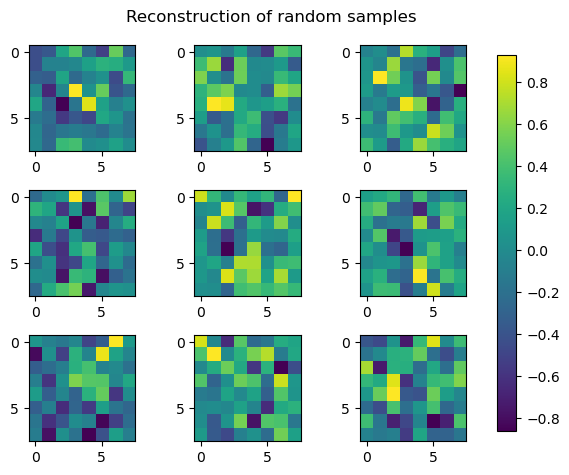

In [902]:
plot_samples(nvp, k=16)